In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import export_graphviz
%matplotlib inline


from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings(action='ignore')

# LogisticRegression

- 선형 회귀 방식을 분류에 적용한 알고리즘
- 선형 회귀와 다른점은 학습을 통해 선형함수의 회귀 최적선을 찾는 것이 아니라 sigmoid함수(0~1값 출력) 최적선을 찾고, <br>
반환 값을 확률로 간주하여 분류 결정

- 위스콘신 유방암 데이터 세트 로드

In [6]:
cancer = load_breast_cancer()

In [7]:
scaler = StandardScaler() #표준화
data_scaled = scaler.fit_transform(cancer.data)
X_train,X_test,y_train,y_test = train_test_split(data_scaled, cancer.target, test_size= 0.3, random_state=0)

In [16]:
lr_clf = LogisticRegression()#로지스틱회귀 적용
lr_clf.fit(X_train, y_train)
print(accuracy_score(y_test,lr_clf.predict(X_test)))
print(roc_auc_score(y_test,lr_clf.predict(X_test)))

0.9766081871345029
0.9715608465608465


### LogisticRegression의  주요 하이퍼 파라미터: penalty, C

- penalty: Regularization의 유형을 설정하며 'l2' / 'l1'으로 설정 가능
- C는 alpha값의 역수이다. (1/alpha) -> 작을수록 규제가 큼

- GrideSearchCV를 이용한 하이퍼 파라미터 최적화

In [23]:
params = {'penalty': ['l2','l1'], 'C':[0.01,0.1,1,1,5,10,100]}
grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring='accuracy',cv=3)
grid_clf.fit(data_scaled, cancer.target)
print(f"최적의 하이퍼 파라미터 :{grid_clf.best_params_}, 최적 평균 정확도:{np.round(grid_clf.best_score_,3)}")

최적의 하이퍼 파라미터 :{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


-----
로지스틱 회귀 특징
- 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어나다. 따라서 로지스틱 회귀를 이진 분류의 기본 모델로 사용하는 경우가 많다.
- 희소한 데이터 세트 분류에도 뛰어난 성능을 보여서 텍스트 분류에도 자주 사용된다.

<br><br>
# Tree

- 보스턴 주택 가격 데이터 세트 로드

In [32]:
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target #결과 컬럼 추가

In [33]:
X_data= bostonDF.drop('PRICE',axis=1)
y_target=  bostonDF['PRICE']

In [28]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [37]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring ="neg_mean_squared_error",cv =5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print(f"-------{model.__class__.__name__}------")
    print(f"5교차 검증의 평균 RMSE: {np.round(avg_rmse,3)}\n")

In [31]:
dt_reg = DecisionTreeRegressor(random_state= 0, max_depth=4)
rf_reg=RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg=GradientBoostingRegressor(random_state = 0, n_estimators=1000)
xgb_reg=XGBRegressor(n_estimators=1000)
lgb_reg= LGBMRegressor(n_estimators=1000)


In [38]:
models=[dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

-------DecisionTreeRegressor------
5교차 검증의 평균 RMSE: 5.978

-------RandomForestRegressor------
5교차 검증의 평균 RMSE: 4.423

-------GradientBoostingRegressor------
5교차 검증의 평균 RMSE: 4.269

-------XGBRegressor------
5교차 검증의 평균 RMSE: 4.251

-------LGBMRegressor------
5교차 검증의 평균 RMSE: 4.646



-----
회귀 트리 Regressor클래스는 선형 회귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없다. <br>
대신 feature_importances_를 이용해 피처별 중요도를 알 수 있음

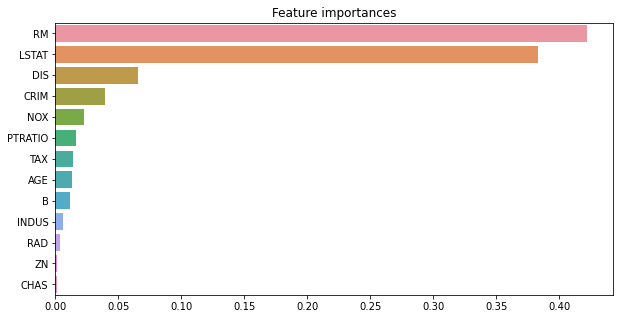

In [44]:
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_data, y_target)
feature_series = pd.Series(data = rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending = False)
plt.figure(figsize=(10,5))
plt.title("Feature importances")
sns.barplot(x= feature_series, y=feature_series.index)
plt.show()

<br><br><br>
- 결정 트리의 하이퍼 파라미터인 max_depth의 크기에 따른 회귀 트리 예측선의 변화 시각화

In [49]:
bostonDF.shape

(506, 14)

In [64]:
#시각화를 위한 color 딕셔너리
color_dic = {0:['#005b6e','#04668c'],1:['#3c6ca7','#786eb7'],2:['#a86bba','#da66ac'],
             3:['#ff6792','#aa6792'],4:['#d8e0bb','#b6cec7'],5:['#ff5050','#ffaa00'],
            6:['#ff99ff','#ff6699',],7:['#e6f2ff','#99ccff'],8:['#ccccff','#cc99ff'],
            9:['#ff9966', '#ff6600']}

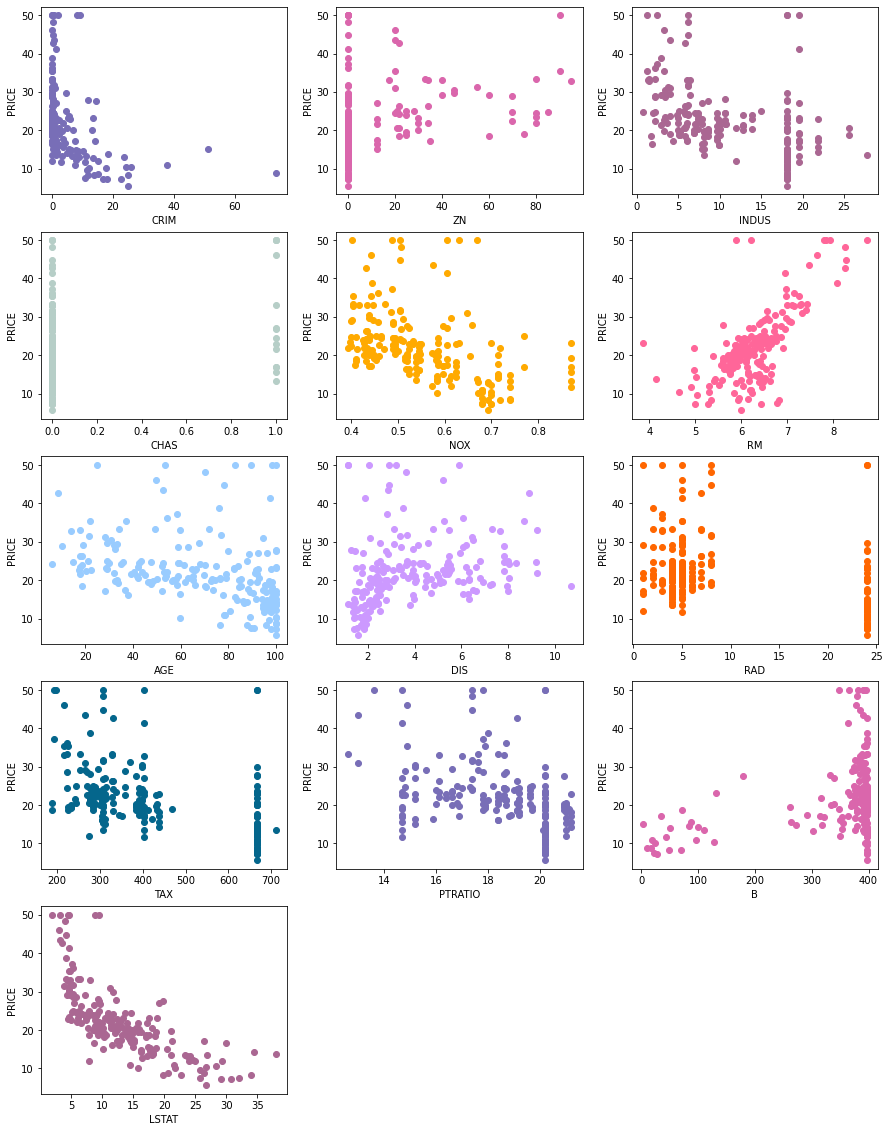

In [67]:
plt.figure(figsize=(15,20))
for e,col in enumerate(bostonDF.drop('PRICE',axis=1).columns,1):
    bostonDF_sample = bostonDF[[col,'PRICE']]
    bostonDF_sample = bostonDF_sample.sample(n=200, random_state = 0)#데이터 200개 샘플링
    plt.subplot(5,3,e)
    plt.scatter(bostonDF_sample[col], bostonDF_sample['PRICE'], color=color_dic[e%len(color_dic)][1])
    plt.xlabel(col)
    plt.ylabel('PRICE')
plt.show()

<br><br>
- 피처 'RM'값을 4.5~8.5까지의 100개의 테스트 데이터 세트로 제공했을 때의 예측값 구하기

In [125]:
#선형회귀와 결정 트리 기반의 Regressor 생성 ( maxdepth = 2, 7)
rf_reg2,rf_reg7,rf_reg5= DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=7), DecisionTreeRegressor(max_depth=5)
lr_reg= LinearRegression()

X_test = np.arange(4.5,8.5,0.04).reshape(-1,1)
X_train = bostonDF['RM'].values.reshape(-1,1)
y_train = bostonDF['PRICE'].values.reshape(-1,1)

In [126]:
lr_reg.fit(X_train, y_train)
rf_reg2.fit(X_train, y_train)
rf_reg7.fit(X_train, y_train)
rf_reg5.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [127]:
lr_pred = lr_reg.predict(X_test)
rf2_pred= rf_reg2.predict(X_test)
rf5_pred = rf_reg5.predict(X_test)
rf7_pred= rf_reg7.predict(X_test)

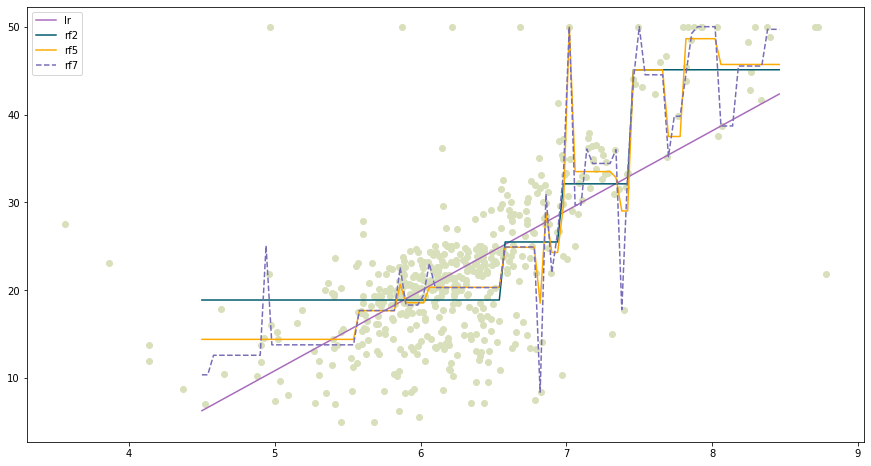

In [139]:
plt.figure(figsize=(15,8))
plt.scatter(X_train, y_train, color=color_dic[4][0])
plt.plot(X_test, lr_pred, color = color_dic[2][0],label='lr')
plt.plot(X_test, rf2_pred, color = color_dic[0][0],label ='rf2')
plt.plot(X_test, rf5_pred, color = color_dic[5][1], ls='-', label='rf5')
plt.plot(X_test, rf7_pred, color = color_dic[1][1], ls='--', label='rf7')
plt.legend()
plt.show()


------
선형회귀는 <strong>직선</strong>으로 예측 회귀선을 표현하는 데 반해, <br>회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 <strong>계단 형태</strong>로 회귀선을 만들었다. <br>
depth=7인 결정트리 모델은 <strong>outlier도 학습</strong>하면서 가장 복잡한 회귀선을 만들었다. 즉, 과적합 되기 쉬운 모델이 되었다.